In [438]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import mutual_info_regression

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping


In [439]:
plt.style.use("seaborn-whitegrid")

In [440]:
#Load data
test_df = pd.read_csv(r'C:\Repositorio\Housing Prices Competition\test.csv') #Test data to 

house_train_df = pd.read_csv(r'C:\Repositorio\Housing Prices Competition\train.csv') #Train data




In [441]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [442]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1044,1045,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,7,2009,WD,Normal,278000
393,394,30,RL,60.0,7446,Pave,Grvl,Reg,Lvl,AllPub,...,0,Fa,GdWo,Shed,0,4,2006,WD,Abnorml,100000
1339,1340,20,RL,120.0,9560,Pave,Pave,IR1,Lvl,AllPub,...,0,Fa,GdWo,TenC,0,6,2006,WD,Normal,128500
1283,1284,90,RL,94.0,9400,Pave,Pave,Reg,Low,AllPub,...,0,Gd,GdWo,Shed,0,4,2010,WD,Normal,139000
141,142,20,RL,78.0,11645,Pave,Pave,Reg,Lvl,AllPub,...,0,Ex,MnPrv,Shed,0,1,2006,WD,Normal,260000


In [443]:
#Analize the NA data

missing = house_train_df.isnull().sum()

total = np.product(house_train_df.shape)
total_missing = missing.sum()

percent_missing = (total_missing/total) * 100

print(percent_missing)


5.889565364451209


In [444]:
#Clean the data
#1. Replace the Na with 0
house_train_df = house_train_df.fillna(method='bfill', axis=0)
house_train_df = house_train_df.dropna()

test_df = test_df.fillna(method='bfill', axis=0)
test_df = test_df.fillna(0)


In [445]:
#Split the data

#train_df = house_train_df.sample(frac = 0.7, random_state=0)
#valid_df = house_train_df.drop(train_df.index)



# Split features and target
#X_train = train_df.drop('SalePrice', axis=1)
#X_valid = valid_df.drop('SalePrice', axis=1)
#y_train = train_df['SalePrice']
#y_valid = valid_df['SalePrice']


X = house_train_df.drop(['SalePrice'], axis=1)
y = house_train_df.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)



OverallQual      0.569213
Neighborhood     0.482528
GrLivArea        0.449458
TotalBsmtSF      0.367967
GarageArea       0.359662
YearBuilt        0.348462
KitchenQual      0.346081
GarageCars       0.338984
ExterQual        0.328512
1stFlrSF         0.307468
MSSubClass       0.303520
BsmtQual         0.301708
FullBath         0.263127
YearRemodAdd     0.247464
2ndFlrSF         0.239517
TotRmsAbvGrd     0.229789
GarageYrBlt      0.217283
Foundation       0.207354
OpenPorchSF      0.191634
GarageFinish     0.177783
Exterior2nd      0.164696
Fireplaces       0.159656
BsmtFinSF1       0.159108
HeatingQC        0.158205
LotFrontage      0.153230
Exterior1st      0.145600
GarageType       0.143414
LotArea          0.138677
MSZoning         0.132642
MasVnrArea       0.130825
BsmtFinType1     0.129334
WoodDeckSF       0.123828
BsmtUnfSF        0.117455
OverallCond      0.111412
HalfBath         0.088971
BedroomAbvGr     0.085238
MasVnrType       0.082063
SaleType         0.073619
HouseStyle  

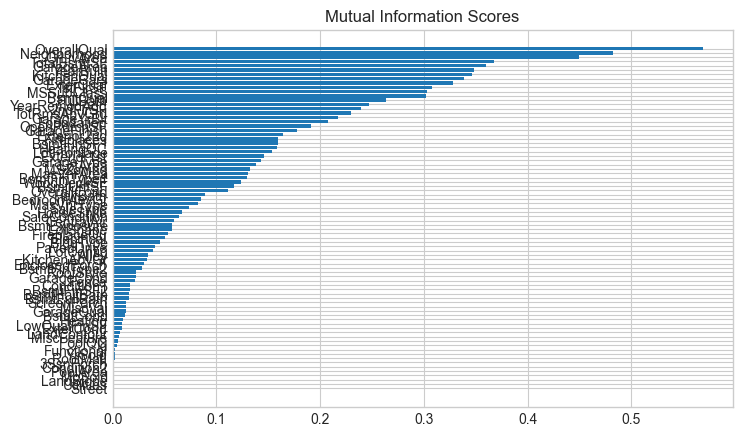

In [446]:
#Apliying mutual information to the data

X = train_df.copy()
y = X.pop("SalePrice")

#Label encoding
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
mi_scores[:40] # show a few features with their MI scores

In [447]:
#Categorical encoding 

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = test_df.copy()

#Apply ordinal encoding

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)

label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])
label_X_test[object_cols] = ordinal_encoder.transform(test_df[object_cols])


Categorical variables:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [448]:
#Define the model

model = keras.Sequential([
    layers.Dense(units=1, activation= 'relu', input_shape=[80])
])

model.compile(
    optimizer="adam",
    loss="mae",
)

In [449]:
#Creating an early stoping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [450]:
#Train the model

history = model.fit(
    label_X_train, y_train,
    validation_data=(label_X_valid, y_valid),
    batch_size=256,
    epochs=10000,
    callbacks=[early_stopping], # put your callbacks in a list
)


Epoch 1/10000
5/5 [==============================] - 2s 119ms/step - loss: 181283.1250 - val_loss: 180164.3438
Epoch 2/10000
5/5 [==============================] - 0s 13ms/step - loss: 181267.4062 - val_loss: 180144.9375
Epoch 3/10000
5/5 [==============================] - 0s 20ms/step - loss: 181248.0469 - val_loss: 180119.2500
Epoch 4/10000
5/5 [==============================] - 0s 14ms/step - loss: 181219.2344 - val_loss: 180082.2188
Epoch 5/10000
5/5 [==============================] - 0s 19ms/step - loss: 181175.4375 - val_loss: 180026.5469
Epoch 6/10000
5/5 [==============================] - 0s 19ms/step - loss: 181112.1406 - val_loss: 179945.1562
Epoch 7/10000
5/5 [==============================] - 0s 17ms/step - loss: 181023.9062 - val_loss: 179837.9844
Epoch 8/10000
5/5 [==============================] - 0s 14ms/step - loss: 180905.8125 - val_loss: 179707.4531
Epoch 9/10000
5/5 [==============================] - 0s 14ms/step - loss: 180765.7812 - val_loss: 179558.7500
Epoch 10/

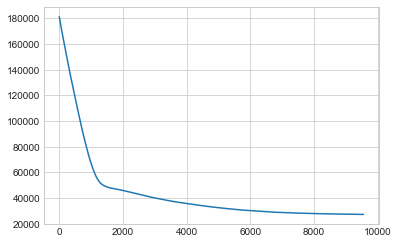

In [451]:
#Analize the results

history_df = pd.DataFrame(history.history)

history_df['loss'].plot();

In [452]:
results = model.predict(label_X_test)

final_result = []
for data in results:
    for result in data:
        final_result.append(result)


results_df = pd.DataFrame(list(zip(label_X_test["Id"], final_result)), columns = ["id","SalePrice"])

results_df.to_csv(r'C:\Repositorio\Housing Prices Competition\Results.csv', index = False)



